# Pycaret with Google Colab

## Contents:
- Part 1: Cleaning and Visualization
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1biEgivJEOUVS8KbeTXyb1lNgsVtbitYj)

- Part 2: Using PyCaret for Model Hyperparameters Tuning
  [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1lXJhdH3rGnKQ_LjBGMh8ZK-Lf2VcfLW5)
- Part 3: Create Model
  [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/14XIC90Lss_izdw-PE1cgIe4eECsXrHbY)



I couldn't install PyCaret and many libraries on my machine (Macbook Air M1), and it is hard to fix, so I decided to use PyCaret libraries on Google Colab instead and it's easier to share with the others to understand the work.

## Preparation 

Install important variables and import to the notebook

In [1]:
# Install pycaret from source for further information. Please check at: https://github.com/pycaret/pycaret
import numpy as np
#!pip3 install 'pycaret[full]'==2.3.10 markupsafe==2.0.1 pyyaml==5.4.1 -qq

In [2]:
# Import libraries
#!pip3 install -U matplotlib
import numpy as np
#from pycaret.utils import enable_colab # enable Pycaret on Colab
import pandas as pd
import jinja2
import matplotlib.pyplot as plt
import matplotlib
import xgboost
from pycaret.regression import *
#enable_colab()

### Import Data

Get the data from my Google Drive. You could check at: [MyGithub](https://github.com/northpr/GermanyRentalPrice)

In [3]:
!gdown --id 1yw4RN-Z9b7PlF45kC5HnXZokaXivk3EV

predict_df = pd.read_csv('predict_test.csv').iloc[:,1:]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1yw4RN-Z9b7PlF45kC5HnXZokaXivk3EV
To: /Users/mac_os/Desktop/DTSENSE/final_project/predict_test.csv
100%|██████████████████████████████████████| 15.0M/15.0M [00:00<00:00, 15.8MB/s]


# Basic inspection
Checking the data before continuing my work to make sure that's everything is on the right track

In [4]:
# Dataframe that I want to use in my prediction
predict_df.head()

,heatingType,totalRent,livingSpace,condition,typeOfFlat,noRooms,regio2,rent_difference,additioncost
0,central_heating,840.00,86.00,well_kept,ground_floor,4.0,Dortmund,245.0,245.0
1,self_contained_central_heating,903.00,84.97,refurbished,apartment,3.0,Bremen,138.0,138.0
2,self_contained_central_heating,380.00,62.00,fully_renovated,apartment,2.0,Mittelsachsen,70.0,70.0
3,central_heating,584.25,60.30,Other,ground_floor,3.0,Bremen,132.0,132.0
4,oil_heating,690.00,53.00,well_kept,roof_storey,2.0,Other,110.0,110.0


In [5]:
print(f"Number of the dataframe: {predict_df.shape[0]}")

Number of the dataframe: 178339


# Start using PyCaret on the df
I will use all of the variables from the 'predict_df'.
You could check how to use PyCaret Tutorial on how to preparation at: [PyCaret Tutorials](https://pycaret.gitbook.io/docs/get-started/tutorials)

Use only basic variables that has a high correlation to the prediction and the easiest choice for the users to get those variables

In [6]:
p_data = predict_df.sample(frac=0.9, random_state=123)
p_data_unseen = predict_df

p_data.reset_index(drop=True, inplace=True)
p_data_unseen.reset_index(drop=True, inplace=True)

print('Data for Modeling: ' + str(p_data.shape))
print('Unseen Data For Predictions ' + str(p_data_unseen.shape))

Data for Modeling: (160505, 9)
Unseen Data For Predictions (178339, 9)


In [7]:
p_data.head()

,heatingType,totalRent,livingSpace,condition,typeOfFlat,noRooms,regio2,rent_difference,additioncost
0,self_contained_central_heating,370.00,53.86,well_kept,roof_storey,3.0,Other,85.0,85.0
1,central_heating,399.00,62.04,Other,apartment,3.0,Plauen,130.0,130.0
2,central_heating,859.17,70.34,Other,ground_floor,3.0,Bielefeld,209.0,209.0
3,central_heating,787.77,74.58,Other,apartment,3.0,Bremen,303.0,303.0
4,central_heating,575.00,48.51,refurbished,apartment,2.0,Dresden,145.0,145.0


### Setting up the PyCaret on prediction data

In [8]:
import jinja2
from pycaret.regression import *

# Setup the data and choose the target for the model.
exp_reg101 = setup(data = p_data, target = 'totalRent', session_id=123, 
                   normalize = True, verbose = False, 
                   remove_multicollinearity = True, multicollinearity_threshold=0.95,experiment_name='experiment_1') 

Exclude model that I don't concern to use in this dataframe due to the complexity of the models.

In [9]:
# Might take around 10-12 mins due to the complexity of Extreme Gradient Boost and CatBoost
best = compare_models(exclude = ['ransac','rf','ada','et','huber','knn','par','omp','dt','en'], n_select=3)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,85.3021,14586.8950,120.7709,0.8435,0.1515,0.1176,1.1810
xgboost,Extreme Gradient Boosting,86.1633,14902.0189,122.0698,0.8402,0.1527,0.1186,0.1610
lightgbm,Light Gradient Boosting Machine,87.5275,15151.3655,123.0855,0.8375,0.1549,0.1211,0.1540
gbr,Gradient Boosting Regressor,91.6590,16299.4127,127.6650,0.8252,0.1612,0.1274,0.8840
lr,Linear Regression,100.6257,18255.8685,135.1111,0.8042,0.1824,0.1461,0.2500
ridge,Ridge Regression,100.6171,18254.6570,135.1066,0.8042,0.1824,0.1461,0.1000
lar,Least Angle Regression,100.6173,18254.6569,135.1066,0.8042,0.1824,0.1461,0.0970
br,Bayesian Ridge,100.6154,18254.6586,135.1066,0.8042,0.1824,0.1461,0.1160
lasso,Lasso Regression,100.5029,18278.9342,135.1966,0.8040,0.1818,0.1457,0.1740
llar,Lasso Least Angle Regression,100.5029,18279.0144,135.1969,0.8040,0.1818,0.1457,0.0950


## CatBoost Regressor

From the table of model comparing above we could see that CatBoost Regressor gives the best result by inspect on MAE, RMSE and R2. So we should consider this model.

In [10]:
catboost_para = create_model('catboost', round=2)
print(catboost_para)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,85.70,14787.58,121.60,0.84,0.15,0.12
1,84.55,14255.31,119.40,0.85,0.15,0.12
2,86.13,14941.71,122.24,0.84,0.15,0.12
3,86.13,14851.70,121.87,0.84,0.15,0.12
4,85.21,14668.23,121.11,0.84,0.15,0.12
5,86.14,14744.92,121.43,0.84,0.15,0.12
6,84.48,14416.31,120.07,0.84,0.15,0.12
7,85.43,14685.74,121.18,0.84,0.15,0.12
8,85.39,14498.86,120.41,0.85,0.15,0.12


In [11]:
print(catboost_para)

### Hyperparameter Tuning
Tunes the 'CatBoost' model. The output of this function is a score grid with CV scores by fold of the best selected model based on optimize parameter.

[PyCaret: tune_model](https://pycaret.readthedocs.io/en/latest/api/regression.html#pycaret.regression.tune_model)

In [12]:
tuned_catboost = tune_model(catboost_para)
print(tuned_catboost)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,85.9850,14937.1955,122.2178,0.8423,0.1531,0.1187
1,85.1868,14441.4282,120.1725,0.8477,0.1521,0.1183
2,86.8557,15142.8415,123.0563,0.8371,0.1538,0.1195
3,86.5840,14972.5844,122.3625,0.8396,0.1526,0.1186
4,85.6316,14824.2103,121.7547,0.8414,0.1526,0.1186
5,86.7015,14885.2340,122.0051,0.8412,0.1529,0.1191
6,85.0323,14613.5433,120.8865,0.8392,0.1521,0.1175
7,85.6484,14784.6922,121.5923,0.8378,0.1516,0.1175
8,85.8356,14698.4494,121.2372,0.8438,0.1518,0.1180


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [13]:
tuned_catboost

### Visualization
From the plot below, we know that the 'CatBoost' considers numerical variables (Living Space, Addition Cost, and No. of Rooms) more important than categorical variables (City, Heating Type, and Room Condition).

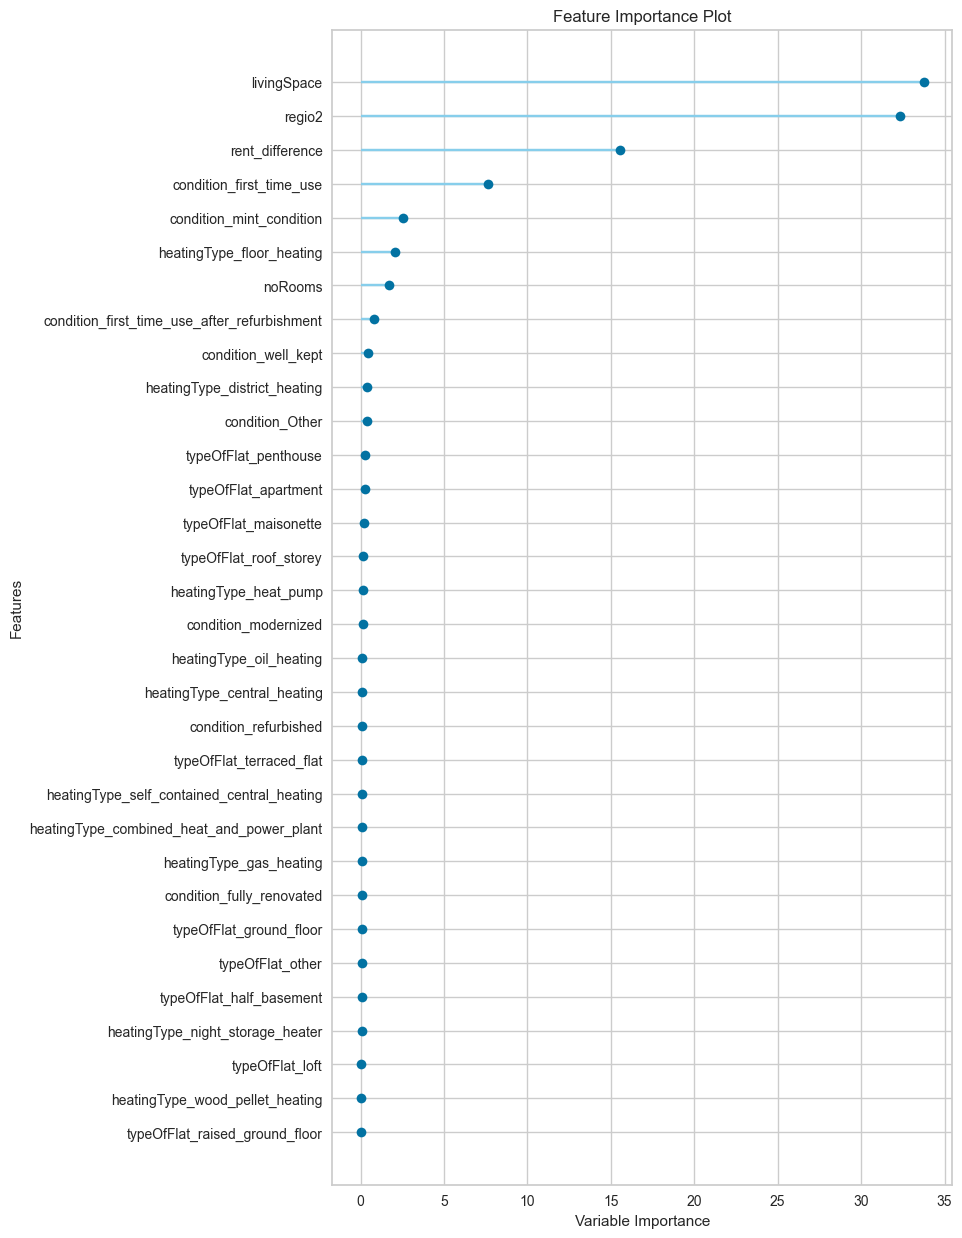

In [14]:
plot_model(tuned_catboost, plot='feature_all')

## Extreme Gradient Boosting

Extreme Gradient Boosting or xgboost is a model that always gives the best result by inspect on MAE, RMSE and R2. So we should keep consider this model for further use.

In [15]:
xgboost_para = create_model('xgboost', round=2)
print(xgboost_para)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,86.55,15075.69,122.78,0.84,0.15,0.12
1,85.39,14622.58,120.92,0.85,0.15,0.12
2,86.99,15229.29,123.41,0.84,0.15,0.12
3,86.81,15105.36,122.90,0.84,0.15,0.12
4,86.07,14987.53,122.42,0.84,0.15,0.12
5,87.23,15096.10,122.87,0.84,0.15,0.12
6,85.37,14771.51,121.54,0.84,0.15,0.12
7,86.18,14909.78,122.11,0.84,0.15,0.12
8,86.16,14821.37,121.74,0.84,0.15,0.12


XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cpu', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=-1,
             num_parallel_tree=None, random_state=123, ...)


### Visualization
From the plot below, we know that the 'Light Gradient Boosting Machine' considers numerical variables (Living Space, Addition Cost, and No. of Rooms) more important than categorical variables (City, Heating Type, and Room Condition).

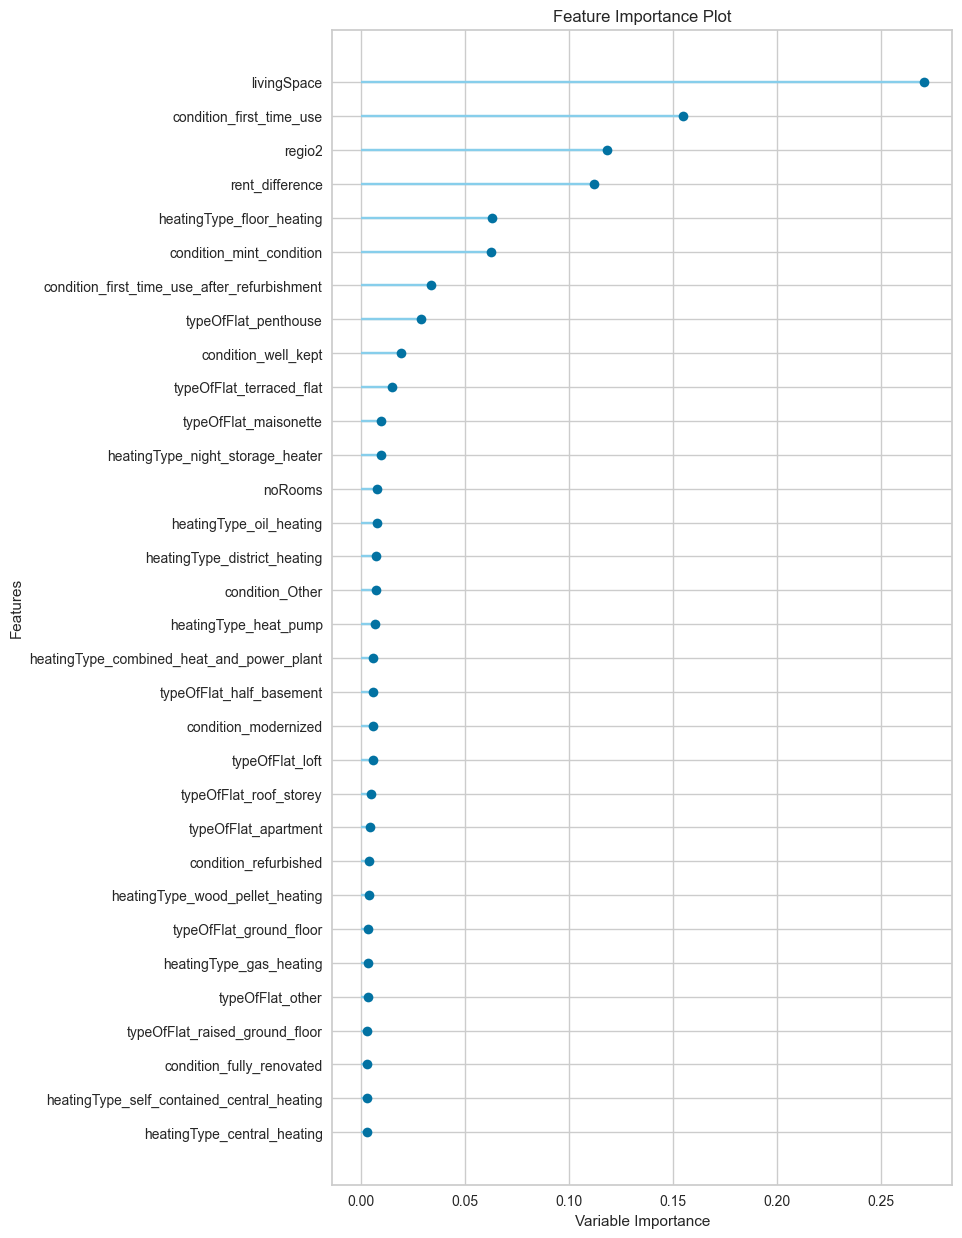

In [16]:
plot_model(xgboost_para, plot='feature_all')

Living Space, Addition Cost and Number of Rooms are the most important so we can make a conclusion that numerical are more important than catgorical variables for Light Gradient Boost

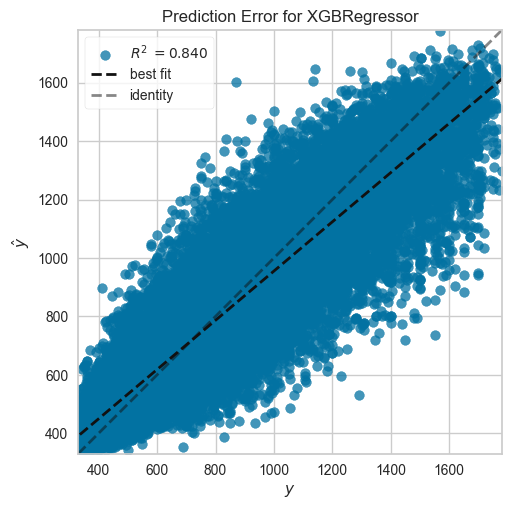

In [17]:
plot_model(xgboost_para, plot = 'error')

In [18]:
xgb_evaluation = predict_model(xgboost_para)
xgb_evaluation;

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extreme Gradient Boosting,86.0520,14865.5908,121.9245,0.8400,0.1525,0.1185


## Light Gradient Boost

From the table of model comparing above we could see that Light Gradient Boosting Machine gives the best result by inspect on MAE, RMSE and R2. So we should keep this model.

In [19]:
lightgbm_para = create_model('lightgbm', round=2)
print(lightgbm_para)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,87.88,15348.62,123.89,0.84,0.16,0.12
1,86.53,14753.76,121.47,0.84,0.15,0.12
2,88.40,15500.80,124.50,0.83,0.16,0.12
3,88.43,15402.75,124.11,0.84,0.16,0.12
4,87.48,15257.14,123.52,0.84,0.16,0.12
5,88.58,15350.15,123.90,0.84,0.16,0.12
6,86.66,15021.99,122.56,0.83,0.15,0.12
7,87.58,15201.62,123.29,0.83,0.15,0.12
8,87.65,15107.39,122.91,0.84,0.15,0.12


LGBMRegressor(n_jobs=-1, random_state=123)


### Hyperparameter Tuning
Tunes the 'Light Gradient Boost' model. The output of this function is a score grid with CV scores by fold of the best selected model based on optimize parameter.

[PyCaret: tune_model](https://pycaret.readthedocs.io/en/latest/api/regression.html#pycaret.regression.tune_model)

In [20]:
tuned_lgb = tune_model(lightgbm_para)
print(tuned_lgb)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,85.5650,14737.3048,121.3973,0.8444,0.1522,0.1181
1,84.7525,14302.4475,119.5928,0.8492,0.1515,0.1177
2,86.3142,14948.3784,122.2636,0.8392,0.1526,0.1187
3,86.5309,14990.9676,122.4376,0.8394,0.1526,0.1186
4,85.3494,14686.3149,121.1871,0.8428,0.1520,0.1183
5,86.0892,14719.6029,121.3244,0.8430,0.1521,0.1184
6,84.5162,14426.2881,120.1095,0.8413,0.1510,0.1168
7,85.5394,14719.4854,121.3239,0.8386,0.1514,0.1175
8,85.4264,14525.9832,120.5238,0.8456,0.1514,0.1178


Fitting 10 folds for each of 10 candidates, totalling 100 fits
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014989 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [I

### Visualization
From the plot below, we know that the 'Light Gradient Boosting Machine' considers numerical variables (Living Space, Addition Cost, and No. of Rooms) more important than categorical variables (City, Heating Type, and Room Condition).

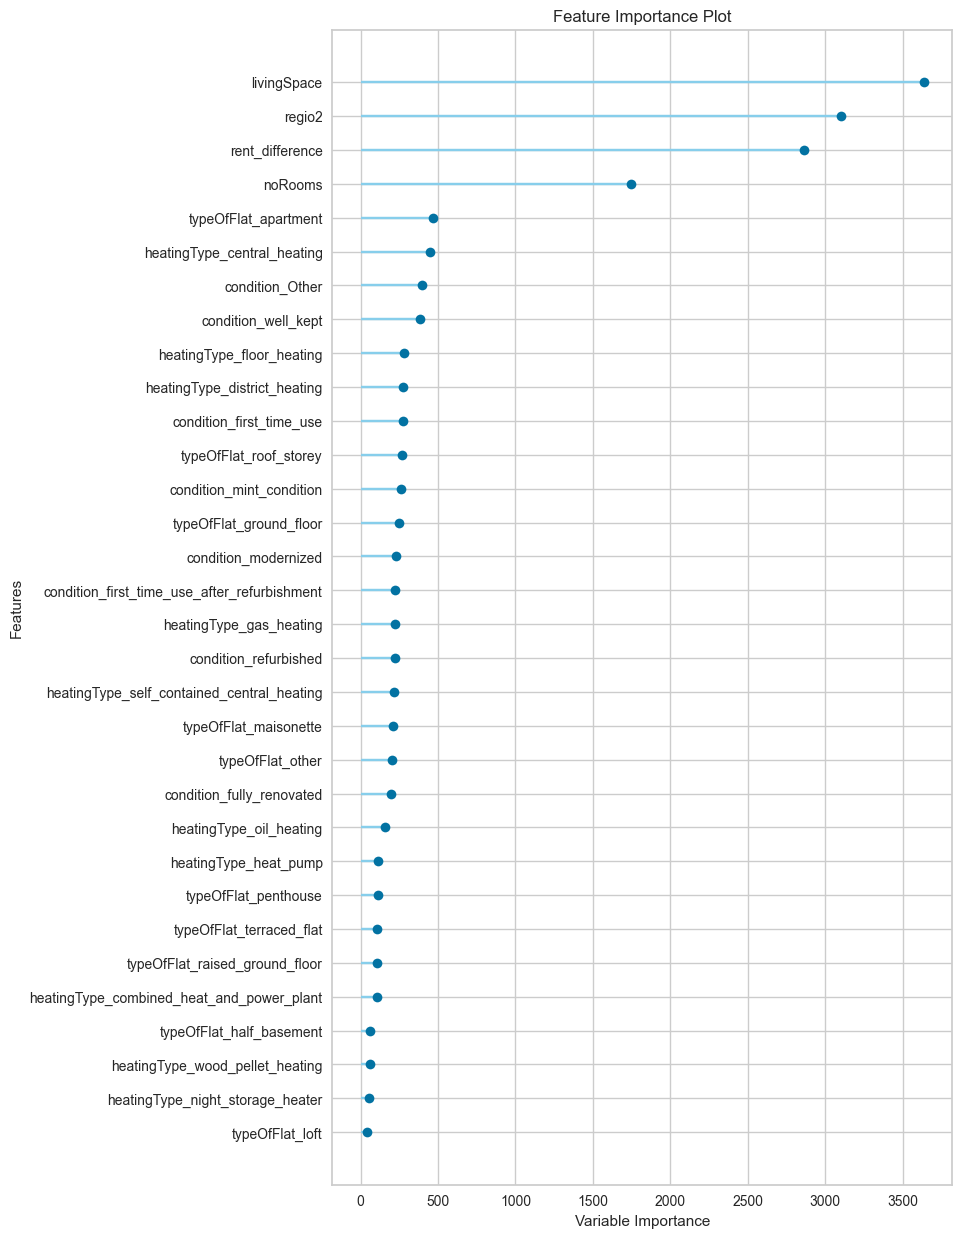

In [21]:
plot_model(tuned_lgb, plot='feature_all')

Living Space, Addition Cost and Number of Rooms are the most important so we can make a conclusion that numerical are more important than catgorical variables for Light Gradient Boost

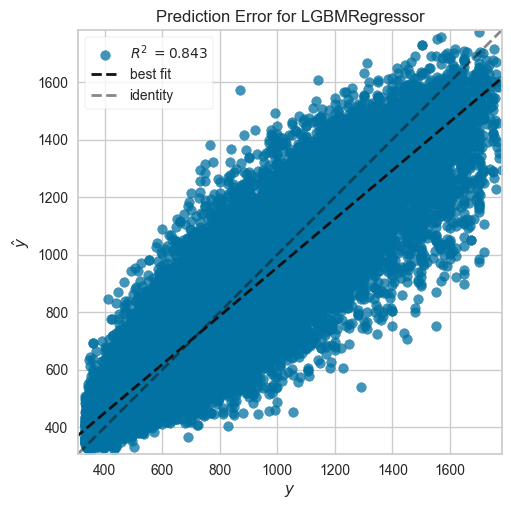

In [22]:
plot_model(tuned_lgb, plot = 'error')

In [23]:
lgb_evaluation = predict_model(tuned_lgb)
lgb_evaluation;

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,85.4642,14604.0643,120.8473,0.8429,0.1516,0.1180


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6


## Linear Regression
Why not compare other models with Linear Regression? It's still the most straightforward model to understand, and we should look at how it decides to compare to LGBM.

Trains and evaluates the performance of a given estimator using cross validation.<br>
[PyCaret: create_model](https://pycaret.readthedocs.io/en/latest/api/regression.html#pycaret.regression.create_model)

In [24]:
lrm = create_model('lr')
print(lrm)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,101.1424,18592.3569,136.3538,0.8037,0.1851,0.1472
1,100.2860,17995.7384,134.1482,0.8102,0.1821,0.1459
2,100.9922,18388.5826,135.6045,0.8022,0.1815,0.1463
3,101.6715,18539.5826,136.1601,0.8014,0.1839,0.1472
4,100.2211,18241.0215,135.0593,0.8048,0.1819,0.1460
5,101.0487,18277.7254,135.1951,0.8050,0.1824,0.1466
6,99.6622,18025.5159,134.2591,0.8017,0.1809,0.1447
7,100.9636,18412.8657,135.6940,0.7981,0.1823,0.1463
8,100.8931,18344.4580,135.4417,0.8050,0.1828,0.1459


LinearRegression(n_jobs=-1)


### Hyperparameter Tuning
Tunes the Linear Regression model. 


In [25]:
tuned_lr = tune_model(lrm)
print(tuned_lr)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,101.1424,18592.3569,136.3538,0.8037,0.1851,0.1472
1,100.2860,17995.7384,134.1482,0.8102,0.1821,0.1459
2,100.9922,18388.5826,135.6045,0.8022,0.1815,0.1463
3,101.6715,18539.5826,136.1601,0.8014,0.1839,0.1472
4,100.2211,18241.0215,135.0593,0.8048,0.1819,0.1460
5,101.0487,18277.7254,135.1951,0.8050,0.1824,0.1466
6,99.6622,18025.5159,134.2591,0.8017,0.1809,0.1447
7,100.9636,18412.8657,135.6940,0.7981,0.1823,0.1463
8,100.8931,18344.4580,135.4417,0.8050,0.1828,0.1459


Fitting 10 folds for each of 2 candidates, totalling 20 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
LinearRegression(n_jobs=-1)


### Visualization
We could know from the plot that Linear Regression consider categorical variable more than numerical variables because it consider the city and room condition before others numerical variables

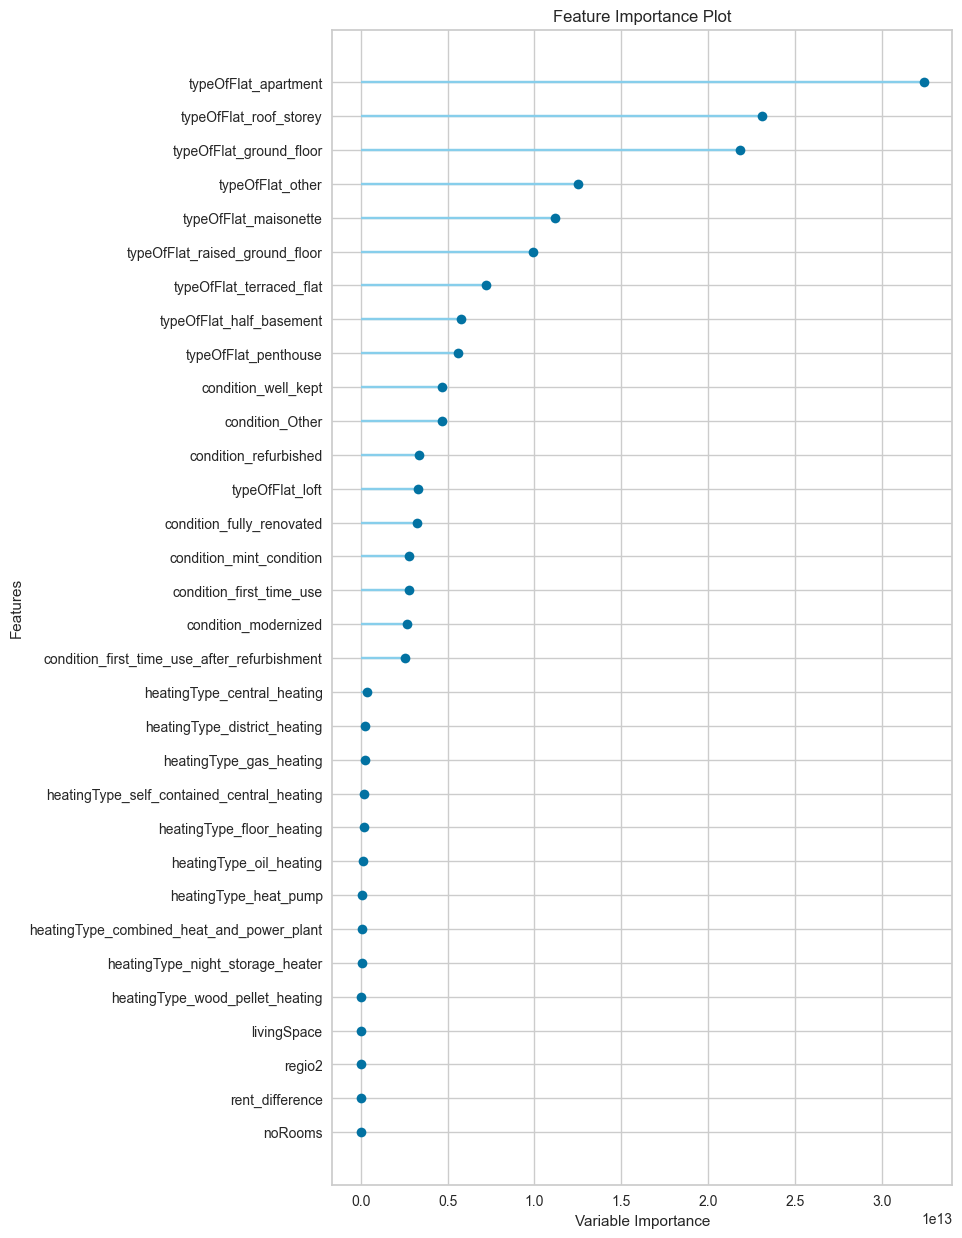

In [26]:
plot_model(tuned_lr, plot='feature_all')

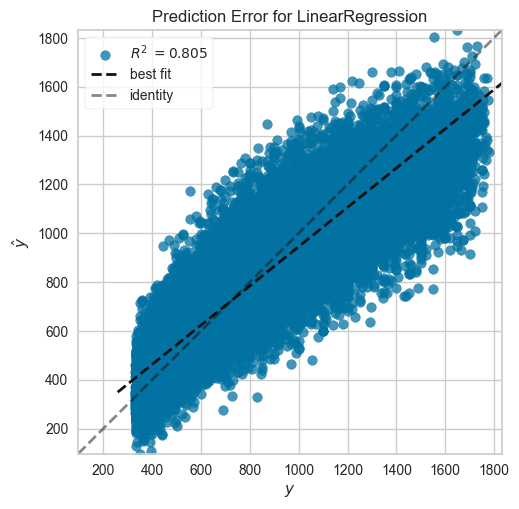

In [27]:
plot_model(tuned_lr, plot = 'error')

In [28]:
lr_evaluation = predict_model(tuned_lr)
lr_evaluation;

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,100.3307,18156.5820,134.7464,0.8046,0.1817,0.1458


## Ridge Regression
Ridge Regression is always my favorite regression algorithm to predict the new datasets if we compare it with linear regression. I always used Ridge Regression because it will be optimized for prediction, so you could use a complex model and avoid overfitting.

In [29]:
ridge_model = create_model('ridge')
print(ridge_model)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,101.1384,18591.7787,136.3517,0.8037,0.1851,0.1472
1,100.2623,17990.9666,134.1304,0.8103,0.1820,0.1459
2,100.9818,18386.4469,135.5966,0.8022,0.1815,0.1463
3,101.6632,18536.8734,136.1502,0.8014,0.1839,0.1472
4,100.2115,18240.7071,135.0582,0.8048,0.1819,0.1460
5,101.0355,18274.9115,135.1847,0.8051,0.1824,0.1465
6,99.6659,18028.1414,134.2689,0.8017,0.1809,0.1447
7,100.9526,18412.6472,135.6932,0.7981,0.1823,0.1463
8,100.8792,18341.4675,135.4307,0.8051,0.1828,0.1459


Ridge(random_state=123)


### Hyperparameter Tuning
Tunes the Ridge Regression model with higher number of iterations. I want to use Ridge Regression as our main predictor because it doesn't give bias or cause overfitting as Linear Regression


In [30]:
tuned_ridge = tune_model(ridge_model)
print(tuned_ridge)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,101.1385,18591.7808,136.3517,0.8037,0.1851,0.1472
1,100.2623,17990.9613,134.1304,0.8103,0.1820,0.1459
2,100.9819,18386.4466,135.5966,0.8022,0.1815,0.1463
3,101.6633,18536.8773,136.1502,0.8014,0.1839,0.1472
4,100.2116,18240.7095,135.0582,0.8048,0.1819,0.1460
5,101.0356,18274.9072,135.1847,0.8051,0.1824,0.1465
6,99.6660,18028.1409,134.2689,0.8017,0.1809,0.1447
7,100.9527,18412.6518,135.6932,0.7981,0.1823,0.1463
8,100.8793,18341.4652,135.4307,0.8051,0.1828,0.1459


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
Ridge(random_state=123)


### Visualization
From the plot below, Ridge Regression mostly worked like Linear Regression by being concerned with the categorical variables more than numerical variables.

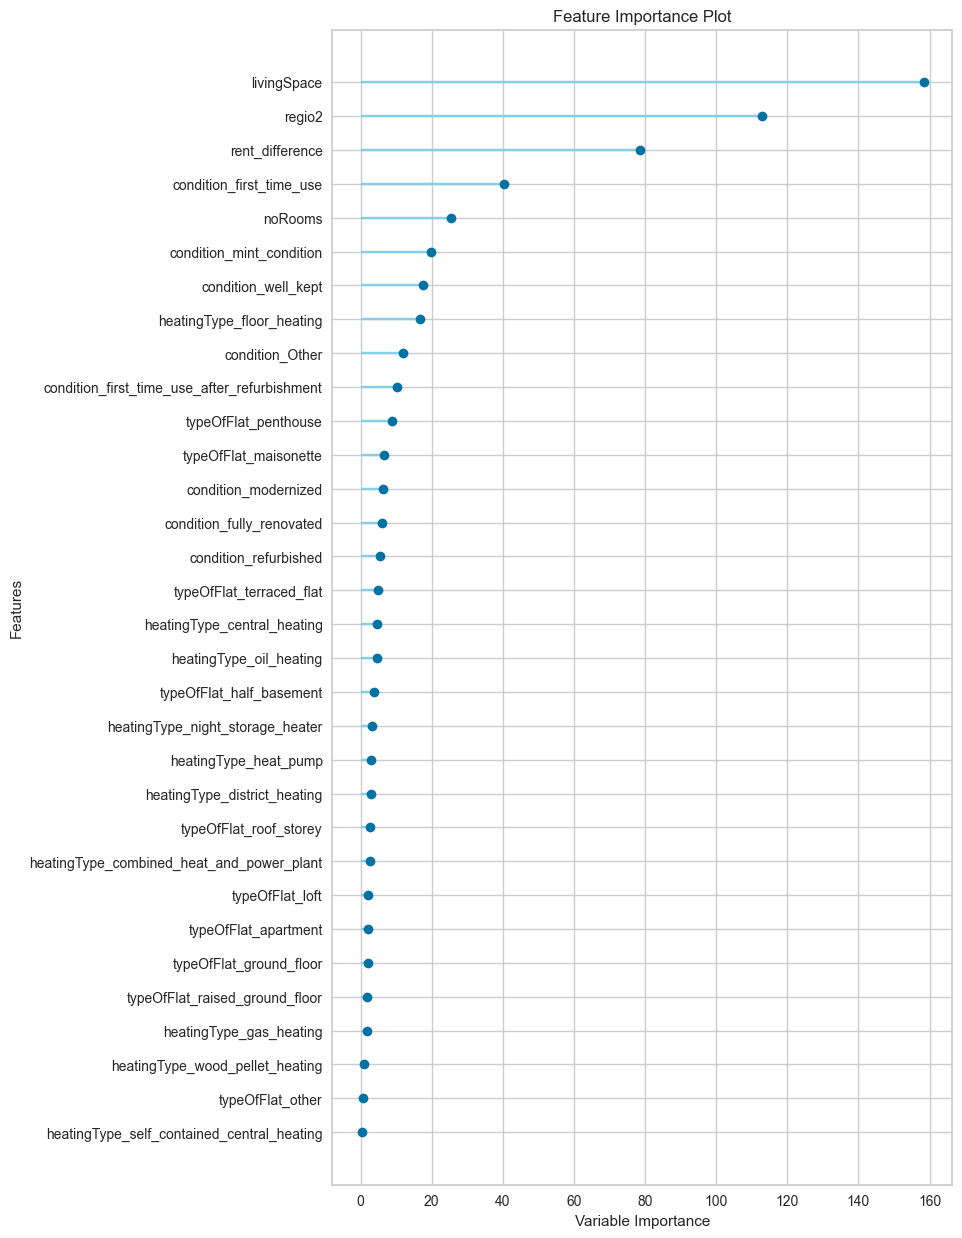

In [31]:
plot_model(tuned_ridge, plot='feature_all')

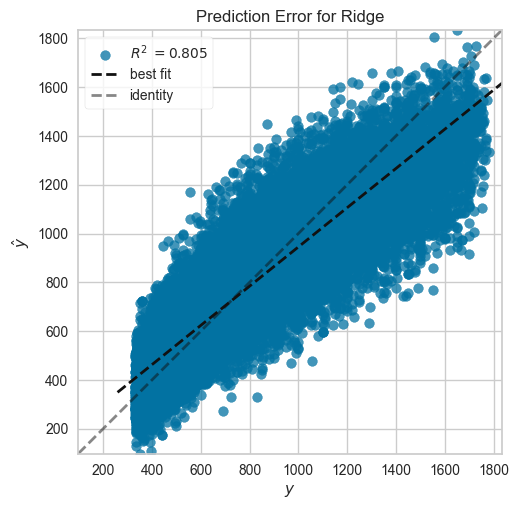

In [32]:
plot_model(tuned_ridge, plot = 'error')

In [33]:
ridge_evaluation = predict_model(tuned_ridge)
ridge_evaluation;

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,100.3200,18155.8451,134.7436,0.8046,0.1817,0.1458
